In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# ====================================================================
# CREATE DATASET 1: RETAIL SALES
# ====================================================================
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
t = np.arange(len(dates))

# Generate sales with trend, seasonality, and holiday effects
trend = 1000 + 15*t
seasonal = 300*np.sin(2*np.pi*t/12) + 200*np.cos(2*np.pi*t/12)
holiday = np.array([400 if i%12==10 else 600 if i%12==11 else 0 for i in range(len(t))])
noise = np.random.normal(0, 80, len(dates))
sales = trend + seasonal + holiday + noise

df_sales = pd.DataFrame({
    'Sales': sales,
    'Month': dates.month,
    'Time': t
}, index=dates)

print("Dataset 1: Retail Sales")
print(f"Shape: {df_sales.shape}")
print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}\n")

Dataset 1: Retail Sales
Shape: (48, 3)
Date range: 2021-01-01 to 2024-12-01




A1: EXPLORATORY VISUALIZATION


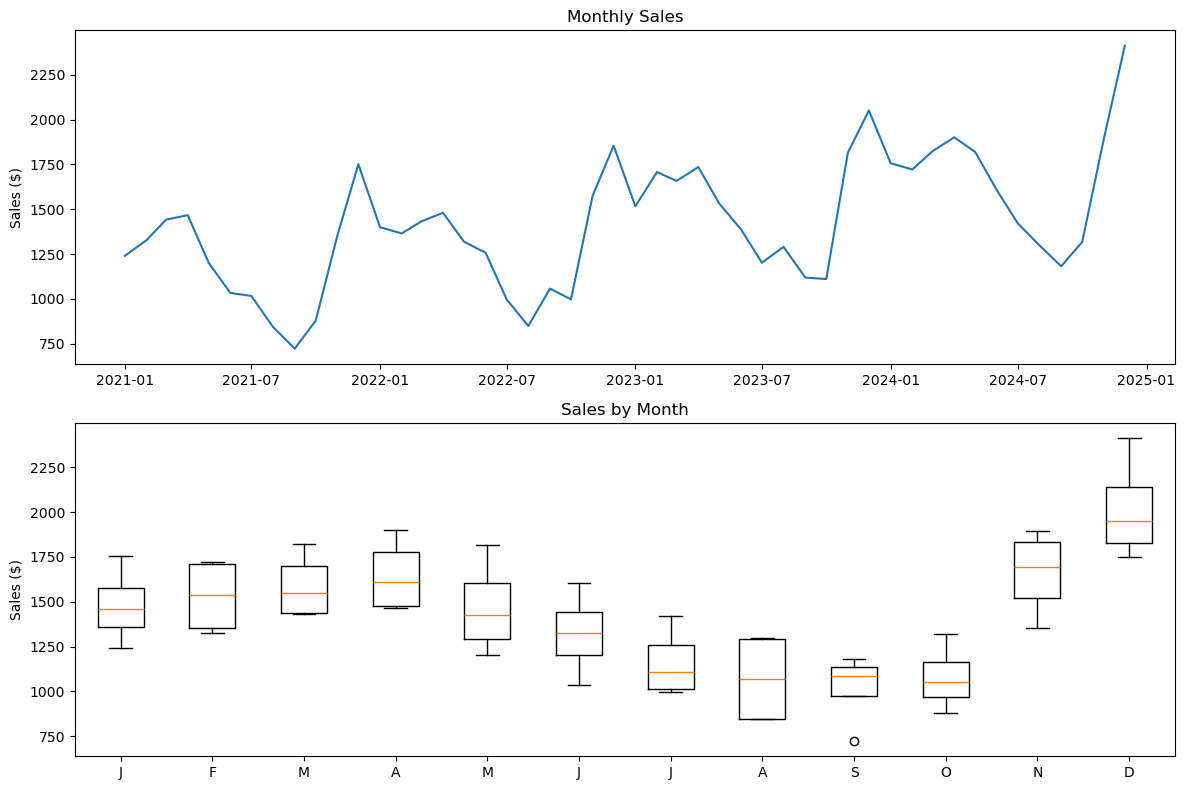

Trend and Nov/Dec seasonality

A2: REGRESSION FORECASTING

Trend: $14.01/month
R²: 0.9662
RMSE: $64.23

A3: FOURIER MODEL
R²: 0.8631
AIC: 614.92
Parameters: 6 (vs 13 for dummies)
Fourier is more parsimonious

A4: SIMPLE EXPONENTIAL SMOOTHING

SES: α=1.000, RMSE=$494.27

A5: HOLT'S METHOD
Holt: α=1.000, β=0.000, RMSE=$620.83

A6: HOLT WINTER'S METHOD
HW: α=0.169, β=0.169, γ=0.000, RMSE=$88.52

 Winner: Holt-Winters (RMSE=$88.52)


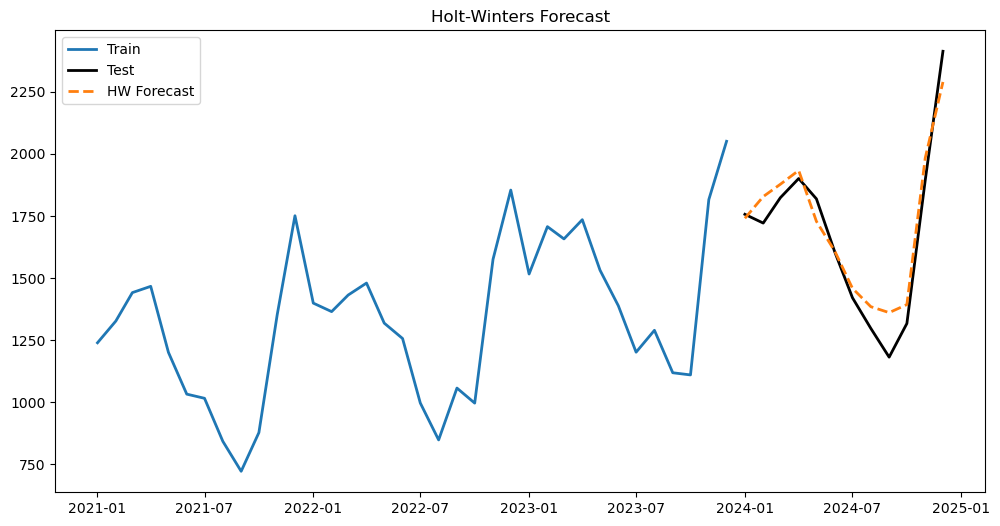


PART B: ARIMA MODELS

B1: STATIONARITY TESTS


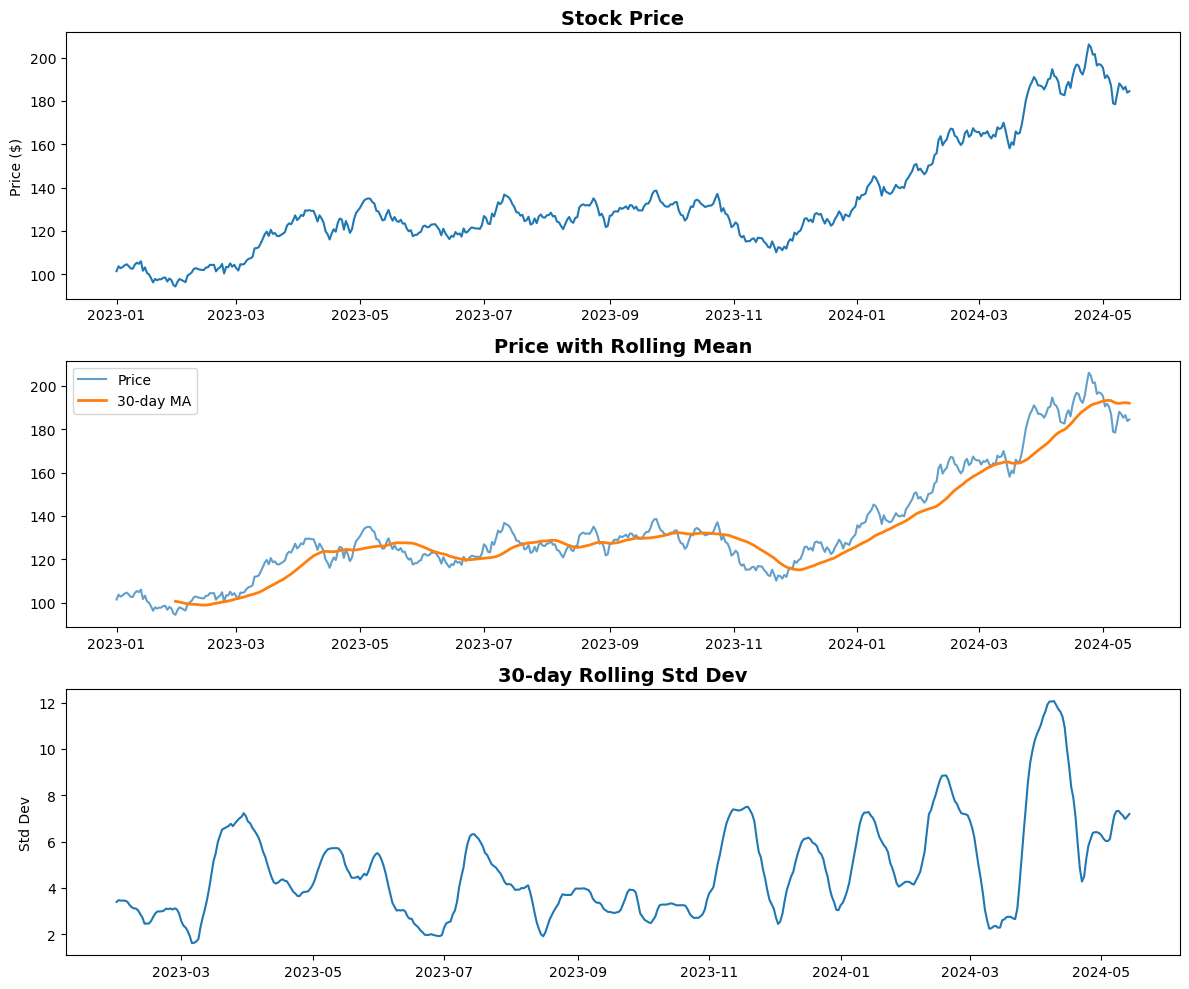


 AUGMENTED DICKEY-FULLER TEST (Price):
Test Statistic: -0.3813
P-value: 0.9132
Critical Values: {'1%': np.float64(-3.4435494520411605), '5%': np.float64(-2.8673612117611267), '10%': np.float64(-2.5698704830567247)}
Decision: FAIL TO REJECT H₀ - Non-stationary

 KPSS TEST (Price):
Test Statistic: 2.7079
P-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Decision: REJECT H₀ - Non-stationary

 Interpretation: Both tests agree - price series is NON-STATIONARY

B2: DIFFERENCING FOR STATIONARITY

 ADF TEST (Differenced Prices):
P-value: 0.000000
Decision: STATIONARY

Correlation (Price_Diff vs Returns): 0.9818
Differenced prices and returns are highly correlated


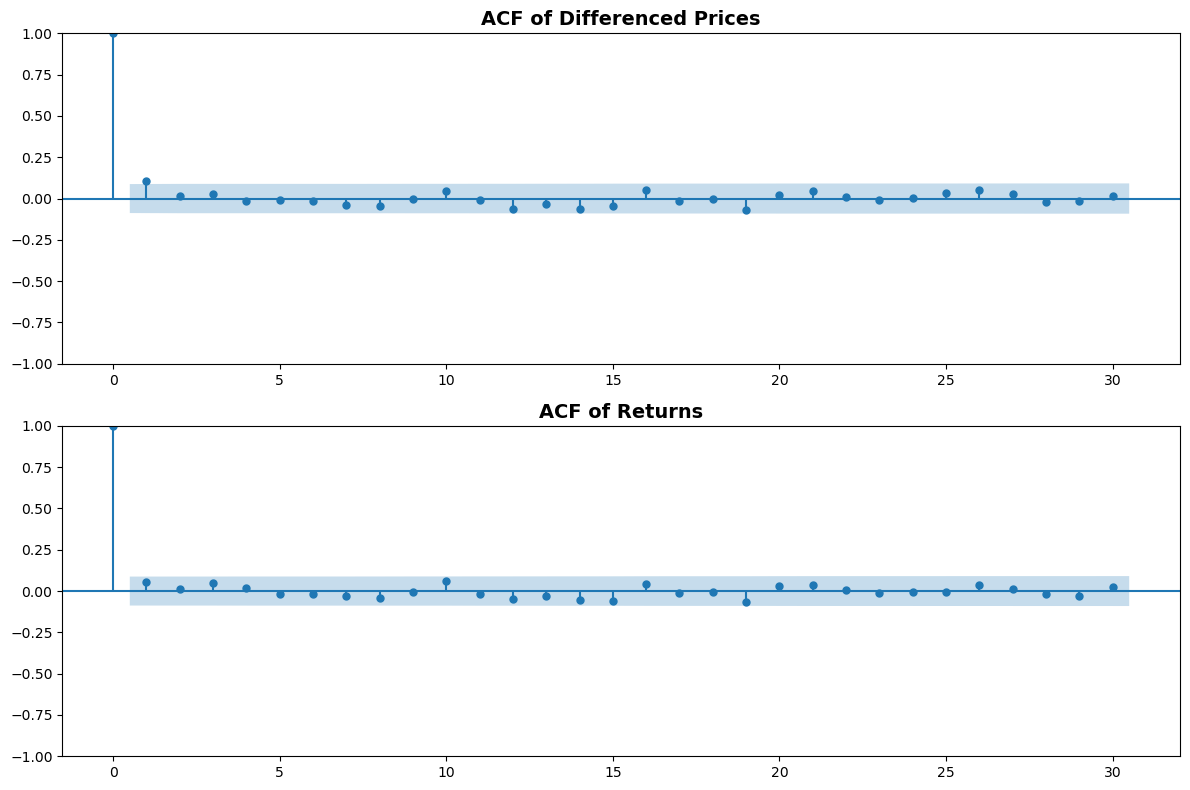


B3: ACF AND PACF ANALYSIS


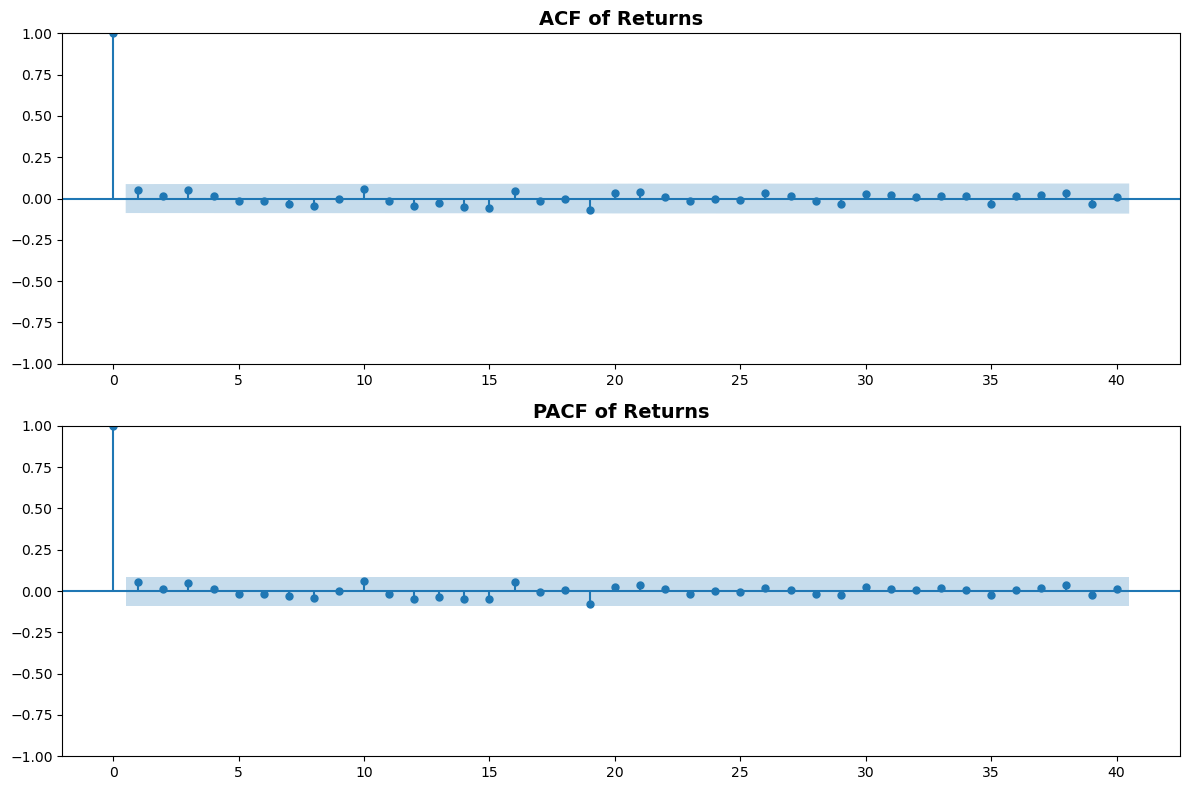


Autocorrelations:
ρ(1) = 0.0535
ρ(5) = -0.0160

 Suggested orders based on plots:
   - Low autocorrelation suggests simple model
   - Try AR(1) or MA(1) first

B4: AR(p) MODELS

AR(1):
  AIC: -2756.40
  Coefficients: [0.05345364]

AR(2):
  AIC: -2754.48
  Coefficients: [0.05051697 0.01259039]

AR(3):
  AIC: -2753.66
  Coefficients: [0.05171472 0.01111478 0.04859309]

B5: MA(q) MODELS

MA(1):
  AIC: -2756.37
  Coefficients: [0.0517135]

MA(2):
  AIC: -2754.41
  Coefficients: [0.05145736 0.01450582]

B6: ARMA(p,q) MODELS

ARMA(1,1):
  AIC: -2754.85
  AR coef: 0.5251
  MA coef: -0.4734

B7: AUTOMATIC SELECTION (Grid Search)

Top 5 Models by AIC:
 p  q          AIC          BIC
 0  0 -2756.972279 -2748.543063
 1  0 -2756.402427 -2743.758602
 0  1 -2756.370203 -2743.726379
 1  1 -2754.850257 -2737.991824
 2  0 -2754.478897 -2737.620465

 Best Model: ARIMA(0,0,0)

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    

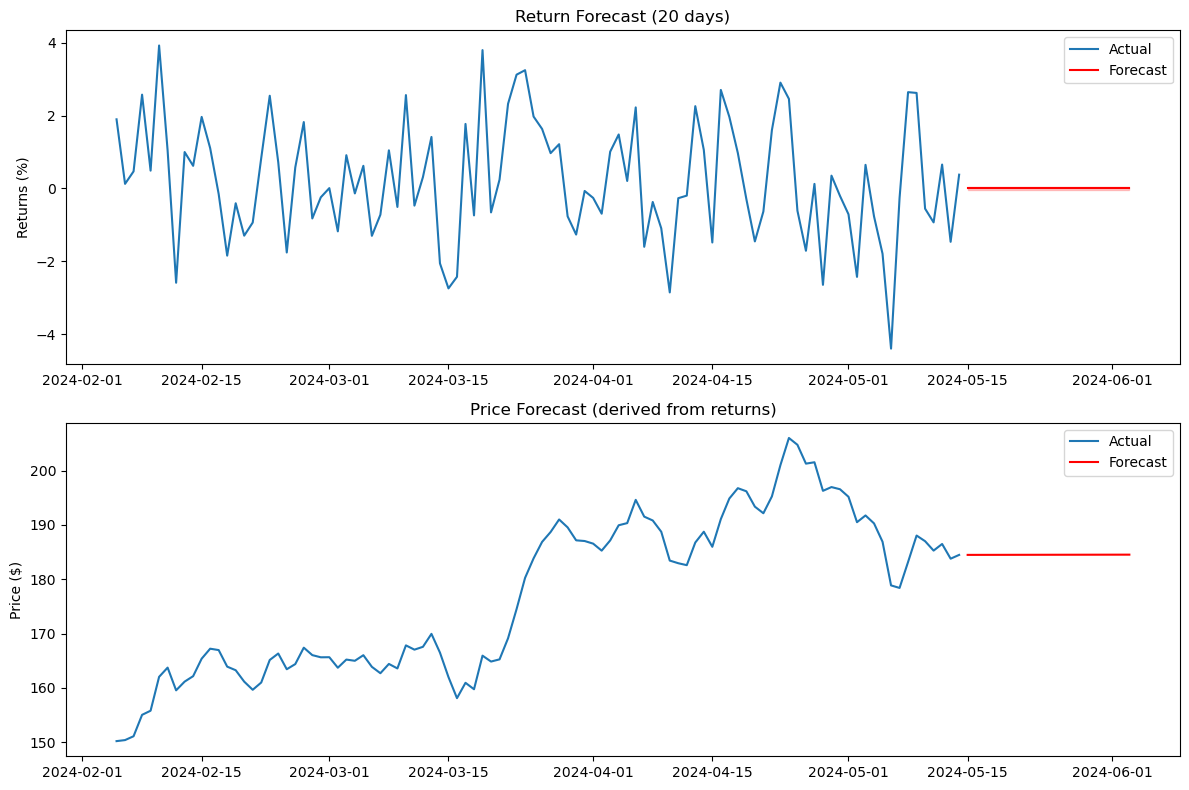


Forecast Insights:
  Return forecasts converge to zero (mean reversion)
  ✓ Uncertainty increases with horizon
  ✓ 20-day price forecast: $184.53



In [21]:
# ====================================================================
# A1: VISUALIZATION
# ====================================================================

print("\n" + "="*70)
print("A1: EXPLORATORY VISUALIZATION")
print("="*70)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Time series
axes[0].plot(df_sales.index, df_sales['Sales'])
axes[0].set_title('Monthly Sales')
axes[0].set_ylabel('Sales ($)')

# Boxplot by month
monthly_data = [df_sales[df_sales['Month']==m]['Sales'] for m in range(1,13)]
axes[1].boxplot(monthly_data, labels=['J','F','M','A','M','J','J','A','S','O','N','D'])
axes[1].set_title('Sales by Month')
axes[1].set_ylabel('Sales ($)')

plt.tight_layout()
plt.show()

print("Trend and Nov/Dec seasonality")

# ====================================================================
# A2: REGRESSION WITH DUMMIES
# ====================================================================
print("\n" + "="*70)
print("A2: REGRESSION FORECASTING")
print("="*70)
month_dummies = pd.get_dummies(df_sales['Month'], drop_first=True, dtype=float)
month_dummies.columns = [f'M_{i}' for i in range(2, 13)]  # M_2, M_3, ..., M_12
X = pd.concat([df_sales[['Time']], month_dummies], axis=1)
X = sm.add_constant(X)

model_reg = sm.OLS(df_sales['Sales'], X).fit()
print(f"\nTrend: ${model_reg.params['Time']:.2f}/month")
print(f"R²: {model_reg.rsquared:.4f}")
print(f"RMSE: ${np.sqrt(np.mean(model_reg.resid**2)):.2f}")

# ====================================================================
# A3: FOURIER TERMS
# ====================================================================
df_sales['sin1'] = np.sin(2*np.pi*df_sales['Time']/12)
df_sales['cos1'] = np.cos(2*np.pi*df_sales['Time']/12)
df_sales['sin2'] = np.sin(4*np.pi*df_sales['Time']/12)
df_sales['cos2'] = np.cos(4*np.pi*df_sales['Time']/12)

X_fourier = sm.add_constant(df_sales[['Time','sin1','cos1','sin2','cos2']])
model_fourier = sm.OLS(df_sales['Sales'], X_fourier).fit()

print("\n" + "="*70)
print("A3: FOURIER MODEL")
print("="*70)
print(f"R²: {model_fourier.rsquared:.4f}")
print(f"AIC: {model_fourier.aic:.2f}")
print(f"Parameters: {len(model_fourier.params)} (vs {len(model_reg.params)} for dummies)")
print("Fourier is more parsimonious")

# ====================================================================
# A4: SIMPLE EXPONENTIAL SMOOTHING
# ====================================================================
train = df_sales['Sales'][:36]
test = df_sales['Sales'][36:]

print("\n" + "="*70)
print("A4: SIMPLE EXPONENTIAL SMOOTHING")
print("="*70)

# Simple Exponential Smoothing
ses = SimpleExpSmoothing(train).fit()
ses_forecast = ses.forecast(12)
rmse_ses = np.sqrt(np.mean((test - ses_forecast)**2))
print(f"\nSES: α={ses.params['smoothing_level']:.3f}, RMSE=${rmse_ses:.2f}")

# ====================================================================
# A5: HOLT'S METHOD
# ====================================================================
print("\n" + "="*70)
print("A5: HOLT'S METHOD")
print("="*70)

# Holt's Method
holt = ExponentialSmoothing(train, trend='add').fit()
holt_forecast = holt.forecast(12)
rmse_holt = np.sqrt(np.mean((test - holt_forecast)**2))
print(f"Holt: α={holt.params['smoothing_level']:.3f}, β={holt.params['smoothing_trend']:.3f}, RMSE=${rmse_holt:.2f}")

# ====================================================================
# A6: HOLT-WINTER'S METHOD
# ====================================================================
print("\n" + "="*70)
print("A6: HOLT WINTER'S METHOD")
print("="*70)

# Holt-Winters
hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw.forecast(12)
rmse_hw = np.sqrt(np.mean((test - hw_forecast)**2))
print(f"HW: α={hw.params['smoothing_level']:.3f}, β={hw.params['smoothing_trend']:.3f}, γ={hw.params['smoothing_seasonal']:.3f}, RMSE=${rmse_hw:.2f}")

print(f"\n Winner: Holt-Winters (RMSE=${rmse_hw:.2f})")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(df_sales.index[:36], train, label='Train', linewidth=2)
plt.plot(df_sales.index[36:], test, label='Test', linewidth=2, color='black')
plt.plot(df_sales.index[36:], hw_forecast, label='HW Forecast', linestyle='--', linewidth=2)
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()

# ====================================================================
# DATASET 2: STOCK RETURNS
# ====================================================================
print("\n" + "="*70)
print("PART B: ARIMA MODELS")
print("="*70)

n_days = 500
dates_stock = pd.date_range('2023-01-01', periods=n_days, freq='D')

returns = np.zeros(n_days)
returns[0] = np.random.normal(0, 0.01)
phi = 0.05
for i in range(1, n_days):
    returns[i] = phi * returns[i-1] + np.random.normal(0, 0.015)

price = 100 * np.exp(np.cumsum(returns))

df_stock = pd.DataFrame({
    'Date': dates_stock,
    'Price': price,
    'Returns': returns * 100
})
df_stock.set_index('Date', inplace=True)

# ====================================================================
# B1: STATIONARITY TESTS
# ====================================================================
print("\n" + "="*70)
print("B1: STATIONARITY TESTS")
print("="*70)

# Visual check
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(df_stock.index, df_stock['Price'])
axes[0].set_title('Stock Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')

rolling_mean = df_stock['Price'].rolling(window=30).mean()
rolling_std = df_stock['Price'].rolling(window=30).std()

axes[1].plot(df_stock.index, df_stock['Price'], label='Price', alpha=0.7)
axes[1].plot(df_stock.index, rolling_mean, label='30-day MA', linewidth=2)
axes[1].set_title('Price with Rolling Mean', fontsize=14, fontweight='bold')
axes[1].legend()

axes[2].plot(df_stock.index, rolling_std)
axes[2].set_title('30-day Rolling Std Dev', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Std Dev')

plt.tight_layout()
plt.savefig('b1_stationarity_visual.png', dpi=300, bbox_inches='tight')
plt.show()

# ADF test
adf_result = adfuller(df_stock['Price'].dropna())
print(f"\n AUGMENTED DICKEY-FULLER TEST (Price):")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print(f"Critical Values: {adf_result[4]}")
print(f"Decision: {'REJECT H₀ - Stationary' if adf_result[1] < 0.05 else 'FAIL TO REJECT H₀ - Non-stationary'}")

# KPSS test
kpss_result = kpss(df_stock['Price'].dropna(), regression='c')
print(f"\n KPSS TEST (Price):")
print(f"Test Statistic: {kpss_result[0]:.4f}")
print(f"P-value: {kpss_result[1]:.4f}")
print(f"Critical Values: {kpss_result[3]}")
print(f"Decision: {'REJECT H₀ - Non-stationary' if kpss_result[1] < 0.05 else 'FAIL TO REJECT H₀ - Stationary'}")

print("\n Interpretation: Both tests agree - price series is NON-STATIONARY")

# ====================================================================
# B2: DIFFERENCING FOR STATIONARITY
# ====================================================================
print("\n" + "="*70)
print("B2: DIFFERENCING FOR STATIONARITY")
print("="*70)

df_stock['Price_Diff'] = df_stock['Price'].diff()

# ADF on differenced series
adf_diff = adfuller(df_stock['Price_Diff'].dropna())
print(f"\n ADF TEST (Differenced Prices):")
print(f"P-value: {adf_diff[1]:.6f}")
print(f"Decision: {'STATIONARY' if adf_diff[1] < 0.05 else 'Non-stationary'}")

# Compare with returns
correlation = df_stock[['Price_Diff', 'Returns']].corr().iloc[0, 1]
print(f"\nCorrelation (Price_Diff vs Returns): {correlation:.4f}")
print("Differenced prices and returns are highly correlated")

# Plot ACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_stock['Price_Diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF of Differenced Prices', fontsize=14, fontweight='bold')

plot_acf(df_stock['Returns'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('ACF of Returns', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('b2_acf_differenced.png', dpi=300, bbox_inches='tight')
plt.show()

# ====================================================================
# B3: ACF AND PACF ANALYSIS
# ====================================================================
print("\n" + "="*70)
print("B3: ACF AND PACF ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_stock['Returns'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF of Returns', fontsize=14, fontweight='bold')

plot_pacf(df_stock['Returns'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('PACF of Returns', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('b3_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate specific autocorrelations
returns_clean = df_stock['Returns'].dropna()
rho_1 = returns_clean.autocorr(lag=1)
rho_5 = returns_clean.autocorr(lag=5)

print(f"\nAutocorrelations:")
print(f"ρ(1) = {rho_1:.4f}")
print(f"ρ(5) = {rho_5:.4f}")

print("\n Suggested orders based on plots:")
print("   - Low autocorrelation suggests simple model")
print("   - Try AR(1) or MA(1) first")

# ====================================================================
# B4: AR(p) MODELS
# ====================================================================
print("\n" + "="*70)
print("B4: AR(p) MODELS")
print("="*70)

# Fit AR(1), AR(2), AR(3)
for p in [1, 2, 3]:
    model = ARIMA(returns, order=(p,0,0)).fit()
    print(f"\nAR({p}):")
    print(f"  AIC: {model.aic:.2f}")
    print(f"  Coefficients: {model.params[1:p+1]}")

# ====================================================================
# B5: MA(q) MODELS
# ====================================================================
print("\n" + "="*70)
print("B5: MA(q) MODELS")
print("="*70)

# Fit MA(1), MA(2)
for q in [1, 2]:
    model = ARIMA(returns, order=(0,0,q)).fit()
    print(f"\nMA({q}):")
    print(f"  AIC: {model.aic:.2f}")
    print(f"  Coefficients: {model.params[1:q+1]}")

# ====================================================================
# B6: ARMA(p,q) MODELS
# ====================================================================
print("\n" + "="*70)
print("B6: ARMA(p,q) MODELS")
print("="*70)

# Fit ARMA(1,1)
model_arma = ARIMA(returns, order=(1,0,1)).fit()
print(f"\nARMA(1,1):")
print(f"  AIC: {model_arma.aic:.2f}")
print(f"  AR coef: {model_arma.params[1]:.4f}")
print(f"  MA coef: {model_arma.params[2]:.4f}")

# ====================================================================
# B7: AUTOMATIC SELECTION (Grid Search)
# ====================================================================
print("\n" + "="*70)
print("B7: AUTOMATIC SELECTION (Grid Search)")
print("="*70)

# Grid search
results = []
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(returns, order=(p,0,q)).fit()
            results.append({'p': p, 'q': q, 'AIC': model.aic, 'BIC': model.bic})
        except:
            continue

results_df = pd.DataFrame(results).sort_values('AIC')
print("\nTop 5 Models by AIC:")
print(results_df.head().to_string(index=False))

# Fit best model
best_p, best_q = int(results_df.iloc[0]['p']), int(results_df.iloc[0]['q'])
best_model = ARIMA(returns, order=(best_p,0,best_q)).fit()
print(f"\n Best Model: ARIMA({best_p},0,{best_q})")
print(f"\nModel Summary:")
print(best_model.summary())
print(f"\nModel Summary:")
print(best_model.summary())

# ====================================================================
# B8: FORECASTING
# ====================================================================
print("\n" + "="*70)
print("B8: ARIMA FORECASTING")
print("="*70)

# Forecast
forecast_result = best_model.get_forecast(steps=20)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Returns forecast
forecast_dates = pd.date_range(df_stock.index[-1] + pd.Timedelta(days=1), periods=20, freq='D')
axes[0].plot(df_stock.index[-100:], df_stock['Returns'].iloc[-100:], label='Actual')
axes[0].plot(forecast_dates, forecast_mean, label='Forecast', color='red')
axes[0].fill_between(forecast_dates, forecast_ci[:, 0], forecast_ci[:, 1], alpha=0.2, color='red')
axes[0].set_title('Return Forecast (20 days)')
axes[0].set_ylabel('Returns (%)')
axes[0].legend()

# Price forecast
last_price = df_stock['Price'].iloc[-1]
forecast_prices = last_price * np.exp(np.cumsum(forecast_mean/100))
axes[1].plot(df_stock.index[-100:], df_stock['Price'].iloc[-100:], label='Actual')
axes[1].plot(forecast_dates, forecast_prices, label='Forecast', color='red')
axes[1].set_title('Price Forecast (derived from returns)')
axes[1].set_ylabel('Price ($)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nForecast Insights:")
print(f"  Return forecasts converge to zero (mean reversion)")
print(f"  Uncertainty increases with horizon")
print(f"  20-day price forecast: ${forecast_prices[-1]:.2f}")

print("\n" + "="*70)
print("="*70)